In [2]:
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import time
import rosbag
from cv_bridge import CvBridge
import cv2
import transforms3d.quaternions as quaternions
import transforms3d.euler as euler
from robot_fk_new import *
from camera import *
from utils import *
from particle_filter import *
from fk_functions import *
import imutils
from scipy import optimize
from scipy.stats import norm

bridge = CvBridge()

In [3]:
# Get a sample data!!
bag = rosbag.Bag('taurus_dataset/close_file1.bag')

robot_state_list = []
robot_state_ts   = []

img_list  = []
img_ts    = []

left_wrist_end_frame_list = []
left_wrist_end_frame_ts = []

opti_left_wrist_list = []
opti_left_wrist_ts = []

for topic, msg, t in bag.read_messages(topics=['/rgb/image_raw', 
                                               '/rgb/camera_info', 
                                               '/joint_states']):
    if topic == '/rgb/image_raw':
        img_list.append(msg)
        img_ts.append(msg.header.stamp.to_sec())
    elif topic == '/joint_states':
        robot_state_list.append(msg)
        robot_state_ts.append(msg.header.stamp.to_sec())
    elif topic == '/rgb/camera_info':
        camera_info = msg
    #elif topic == '/tf':
    #    if msg.transforms[0].child_frame_id == "left_wrist_end_frame":
    #        left_wrist_end_frame_list.append(msg.transforms[0])
    #        left_wrist_end_frame_ts.append(msg.transforms[0].header.stamp.to_sec())
    #    elif msg.transforms[0].child_frame_id == "opti_left_wrist":
    #        opti_left_wrist_list.append(msg.transforms[0])
    #        opti_left_wrist_ts.append(msg.transforms[0].header.stamp.to_sec())
        

bag.close()

In [5]:
P = np.array(camera_info.P).reshape(3,4)[:,:3]
D = np.array(camera_info.D)
offset = np.array([camera_info.roi.x_offset,camera_info.roi.y_offset])

img_ts  = np.array(img_ts)
robot_state_ts = np.array(robot_state_ts)
#left_wrist_end_frame_ts = np.array(left_wrist_end_frame_ts)

camera = Camera(P,D,offset)



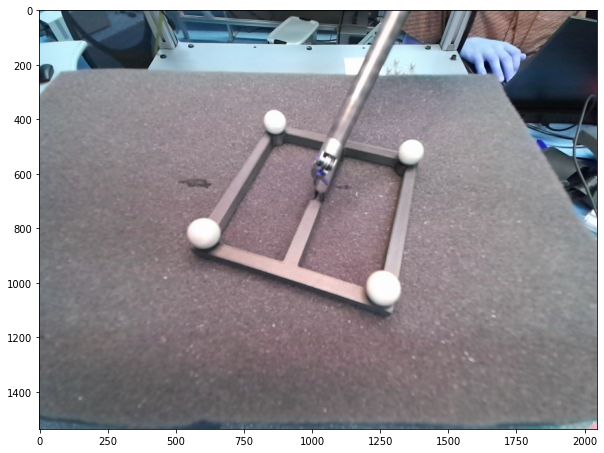

In [6]:
img_idx = 120
t = img_ts[img_idx]
robot_state_msg_idx = np.argmin(np.abs(t - robot_state_ts))
left_joint_angles = robot_state_list[robot_state_msg_idx]
left_joint_angles_orderred = np.array(left_joint_angles.position)[[2, 4, 3, 0, 6, 5, 7]]

#tf_msg_idx = np.argmin(np.abs(t - left_wrist_end_frame_ts))
#tf_msg = left_wrist_end_frame_list[tf_msg_idx]

cv_img = bridge.imgmsg_to_cv2(img_list[img_idx], desired_encoding="passthrough")
img = cv_img[:,:,:3].copy()

plt.figure(figsize=(10,10))

plt.imshow(img)

In [7]:
def segmentColorAndGetKeyPoints(img, hsv_min=(90, 40, 40), hsv_max=(120, 255, 255), draw_contours=False):
    hsv = cv2.cvtColor(img,  cv2.COLOR_RGB2HSV)
    mask  = cv2.inRange(hsv , hsv_min, hsv_max)
    mask  = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((5,5),np.uint8))

    cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnts = imutils.grab_contours(cnts)

    centroids = []
    for c in cnts:
        # compute the center of the contour
        M = cv2.moments(c)
        if M["m00"] == 0:
            cX = M["m10"]
            cY = M["m01"]
        else:
            cX = M["m10"] / M["m00"]
            cY = M["m01"] / M["m00"]
        centroids.append(np.array([cX, cY]))

    if draw_contours:
        cv2.drawContours(img, cnts, -1, (255, 0, 0), thickness=3)
    
    return np.array(centroids), img

In [8]:
hsv_min=(120, 40, 40)
hsv_max=(150, 255, 255)
centroids, img = segmentColorAndGetKeyPoints(img, hsv_min, hsv_max, draw_contours=True)
centroids

array([[1068.        ,  645.        ],
       [1051.09100877,  626.40131579],
       [1082.5       ,  604.5       ],
       [1024.93366398,  599.48915065],
       [1022.97976571,  538.00106496],
       [2021.71130358,  305.78969576],
       [2025.5       ,  290.        ],
       [2018.22830261,  267.9796467 ],
       [2045.5       ,  248.        ],
       [2035.76666667,  247.08611111],
       [2034.        ,  206.        ],
       [1793.        ,  165.        ],
       [1394.5       ,  115.        ],
       [1586.        ,   26.        ]])

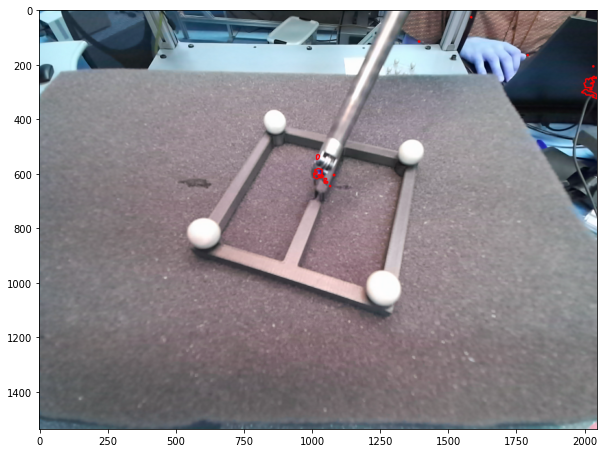

In [9]:
plt.figure(figsize=(10,10))

plt.imshow(img)

In [10]:
taurus = Taurus_FK("point_feature_new.json")


In [11]:
T_b_c = np.array([[-0.0086596 ,  0.86086372, -0.50876189, 0.667792],
                  [-0.9999511 , -0.00502532,  0.00851687, -0.027447],
                  [ 0.00477517,  0.50881076,  0.86086515, -0.0123208],
                  [ 0.0       , 0.0        , 0.0        , 1.0     ]])
T_c_b = np.linalg.inv(T_b_c)


In [12]:
rvec_init = cv2.Rodrigues(T_c_b[:3,:3])[0].squeeze()
tvec_init = T_c_b[:3,-1]

In [13]:
image = img.copy()

In [14]:
T_J5 = taurus.get_elbow_transfrom(left_joint_angles_orderred[0],\
                            left_joint_angles_orderred[1],\
                                left_joint_angles_orderred[2],\
                                    left_joint_angles_orderred[3])

T_J6 = taurus.get_end_frame_transform(left_joint_angles_orderred[0],\
                            left_joint_angles_orderred[1],\
                                left_joint_angles_orderred[2],\
                                    left_joint_angles_orderred[3],\
                                        left_joint_angles_orderred[4],\
                                            left_joint_angles_orderred[5],\
                                                left_joint_angles_orderred[6])
ori = T_J6 @ np.array([0,0,0,1])
x = T_J6 @ np.array([0.05,0,0,1])
y = T_J6 @ np.array([0,0.05,0,1])
z = T_J6 @ np.array([0,0,0.05,1])

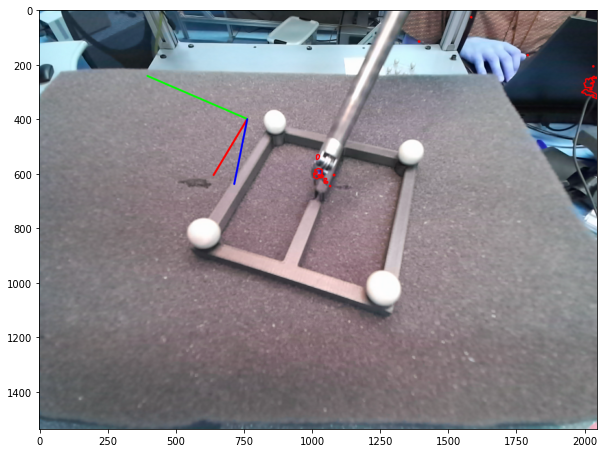

In [15]:
px,_ = cv2.projectPoints(x[:3], rvec_init, tvec_init, P, D)
py,_ = cv2.projectPoints(y[:3], rvec_init, tvec_init, P, D)
pz,_ = cv2.projectPoints(z[:3], rvec_init, tvec_init, P, D)
po,_ = cv2.projectPoints(ori[:3], rvec_init, tvec_init, P, D)

color = (255,0,0)
image = cv2.line(image, tuple(po.squeeze().astype(int)), tuple(px.squeeze().astype(int)), 
                                 (255,0,0), 5)
image = cv2.line(image, tuple(po.squeeze().astype(int)), tuple(py.squeeze().astype(int)), 
                                 (0,255,0), 5)
image = cv2.line(image, tuple(po.squeeze().astype(int)), tuple(pz.squeeze().astype(int)), 
                                 (0,0,255), 5)

plt.figure(figsize=(10,10))

plt.imshow(image)

roll_1:front
[[[792.21904771 295.31024013]]]
roll_1:back
[[[796.61251146 303.40868718]]]
roll_2:right
[[[802.06200841 358.3584007 ]]]
roll_2:left
[[[748.53515791 326.09518939]]]
pitch_2:front
[[[763.62101397 358.28318716]]]
pitch_2:back
[[[770.92828745 363.4995801 ]]]
pitch_1:right
[[[783.85902212 377.76135133]]]
pitch_1:left
[[[745.87025824 355.56374892]]]
pitch_3:front
[[[759.21157287 408.07780712]]]
pitch_3:back
[[[769.68037252 390.38434969]]]


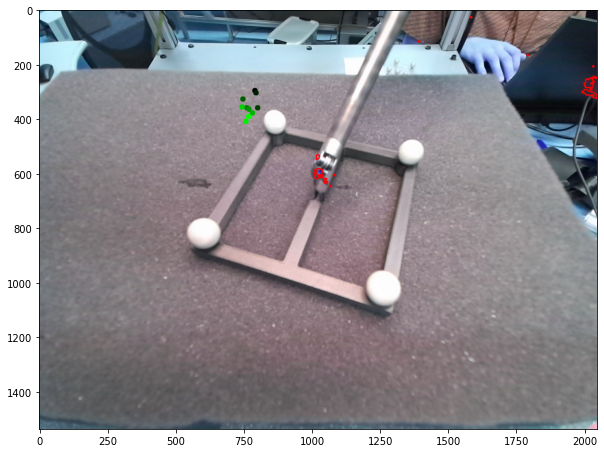

In [16]:
point_features = taurus.get_point_features(left_joint_angles_orderred)


image = img.copy()

c = 0
for key in list(point_features.keys())[:]:
    print(key)
    p = point_features[key]
    point,_ = cv2.projectPoints(p, rvec_init, tvec_init, P, D)
    print(point)
    image = cv2.circle(image,tuple(point.squeeze().astype(int)), 10, (0,c,0), -1)

    c+=30


plt.figure(figsize=(10,10))

plt.imshow(image)

In [17]:
#kwargs must have init_rvec, init_tvec, and joint_angles
def project_feature_points(x, **kwargs):
    

    theta = kwargs["joint_angles"]
    robot = kwargs["robot"]
    cam = kwargs["camera"]
    point_features = taurus.get_point_features(theta)

    f0 = point_features['roll_1:front']
    f1 = point_features['roll_1:back']
    f2 = point_features['roll_2:right']
    f3 = point_features['roll_2:left']
    f4 = point_features['pitch_1:right']
    f5 = point_features['pitch_1:left']
    f6 = point_features['pitch_2:front']
    f7 = point_features['pitch_2:back']
    #f8 = point_features['pitch_3:front']
    #f9 = point_features['pitch_3:back']



    n_points = len(point_features.keys())
    y = np.zeros((x.shape[0], n_points, 2))



    for i, particle in enumerate(x):
        
        rvec, tvec = cv2.composeRT( kwargs["init_rvec"], kwargs["init_tvec"], particle[3:], particle[:3])[:2]
        
        p0,_ = cv2.projectPoints(f0, rvec, tvec, cam.P,cam.D)
        p0 = np.squeeze(p0) - cam.offset
        y[i, 0] = p0
        p1,_ = cv2.projectPoints(f1, rvec, tvec, cam.P,cam.D)
        p1 = np.squeeze(p1) - cam.offset
        y[i, 1] = p1
        p2,_ = cv2.projectPoints(f2, rvec, tvec, cam.P,cam.D)
        p2 = np.squeeze(p2) - cam.offset
        y[i, 2] = p2
        p3,_ = cv2.projectPoints(f3, rvec, tvec, cam.P,cam.D)
        p3 = np.squeeze(p3) - cam.offset
        y[i, 3] = p3
        p4,_ = cv2.projectPoints(f4, rvec, tvec, cam.P,cam.D)
        p4 = np.squeeze(p4) - cam.offset
        y[i, 4] = p4
        p5,_ = cv2.projectPoints(f5, rvec, tvec, cam.P,cam.D)
        p5 = np.squeeze(p5) - cam.offset
        y[i, 5] = p5
        p6,_ = cv2.projectPoints(f6, rvec, tvec, cam.P,cam.D)
        p6 = np.squeeze(p6) - cam.offset
        y[i, 6] = p6
        p7,_ = cv2.projectPoints(f7, rvec, tvec, cam.P,cam.D)
        p7 = np.squeeze(p7) - cam.offset
        y[i, 7] = p7
        #p8,_ = cv2.projectPoints(f8, rvec, tvec, cam.P,cam.D)
        #p8 = np.squeeze(p8) - cam.offset
        #y[i, 8] = p8
        #p9,_ = cv2.projectPoints(f9, rvec, tvec, cam.P,cam.D)
        #p9 = np.squeeze(p9) - cam.offset
        #y[i, 9] = p9
        
    return y

In [18]:
# Note that hypotheses is of dimensions N (number of particles) by P (number of features) by 2 
# and observed is of dimensions P by 2

def weight_function(hypotheses, observed, **kwargs):
    n_particles = hypotheses.shape[0]
    weights = np.zeros(n_particles)

    for i in range(n_particles):
        projected_points = hypotheses[i]
        # Use hungarian algorithm to match projected and detected points
        C = np.linalg.norm(projected_points[:, None, :] - observed[None, :,  :], axis=2)
        #print(C)
        row_idx, col_idx = optimize.linear_sum_assignment(C)

        # Use threshold to remove outliers
        idx_to_keep = C[row_idx, col_idx] < kwargs["association_threshold"]
        row_idx = row_idx[idx_to_keep]
        col_idx = col_idx[idx_to_keep]

        # Compute observation probability
        prob = np.mean(np.exp(-kwargs["gamma"]*C[row_idx, col_idx])) 
        #print(prob)
        weights[i] = prob

    weights[np.isnan(weights)] = 0        

    return weights


# tracking with particle filter 

In [19]:
# particle filter parameters
sigma_t = 0.01 #0.005 #inch
sigma_r = 0.003   #0.035 #2 degrees
#sigma_j = 0.001
#u_j     = 0.002
scale_init_sigma = 10
gamma = 0.5 # 1
association_threshold=50
n_particles = 200
n_eff = 0.5
resample_proportion = 0

# initialize particle filter
pf = ParticleFilter(prior_fn=lambda n : prior_fn(n, scale_init_sigma, sigma_t, sigma_r), 
                    observe_fn=project_feature_points,
                    n_particles=n_particles,
                    dynamics_fn=identity,
                    noise_fn=lambda x, **kwargs: 
                                gaussian_noise(x, sigmas=[sigma_t, sigma_t, sigma_t, 
                                                          sigma_r, sigma_r, sigma_r]),
                    weight_fn=weight_function,
                    resample_proportion=resample_proportion,
                    resample_fn = stratified_resample,
                    n_eff_threshold = n_eff)
pf.init_filter() 


2.451708102262559e-18
[[[960.40494108 444.85621626]]]
[[[956.01271773 444.94164105]]]
[[[962.34018852 502.03587678]]]
[[[910.89350644 471.8709884 ]]]
[[[926.93374067 505.51649816]]]
[[[928.3162929  505.16883162]]]
[[[944.54036662 522.65188251]]]
[[[905.17349196 499.2635391 ]]]
[[[914.49677218 549.04854702]]]
[[[921.47386909 527.46250631]]]


/home/jingpei/anaconda3/envs/pytorch_ros/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jingpei/anaconda3/envs/pytorch_ros/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jingpei/Desktop/surgical_tool_tracking/particle_filter.py:364: RuntimeWarning: divide by zero encountered in log
  self.weight_entropy = np.sum(self.weights * np.log(self.weights))
/home/jingpei/Desktop/surgical_tool_tracking/particle_filter.py:364: RuntimeWarning: invalid value encountered in multiply
  self.weight_entropy = np.sum(self.weights * np.log(self.weights))
/home/jingpei/Desktop/surgical_tool_tracking/particle_filter.py:372: RuntimeWarning: Degrees of freedom <= 0 for slice
  self.cov_state = np.cov(self.particles, rowvar=False, aweights=self.weights)
/home/jingpei/anaconda3/envs/pytorch_ros/

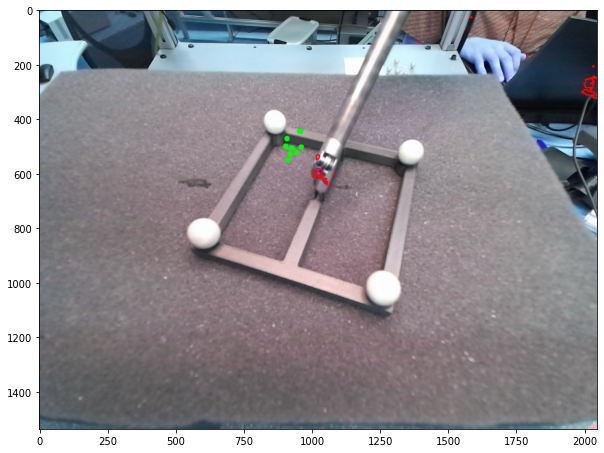

In [20]:
idx = 120
# receive images
cv_img = bridge.imgmsg_to_cv2(img_list[idx], desired_encoding="passthrough")
img = cv_img[:,:,:3].copy()

# receive joint angles
t = img_ts[idx]
robot_state_msg_idx = np.argmin(np.abs(t - robot_state_ts))
left_joint_angles = robot_state_list[robot_state_msg_idx]
left_joint_angles_orderred = np.array(left_joint_angles.position)[[2, 4, 3, 0, 6, 5, 7]]

# detect point features
centroids, img = segmentColorAndGetKeyPoints(img, hsv_min, hsv_max, draw_contours=True)

# estimate with particle filter
pf.update(centroids, init_rvec=rvec_init, init_tvec=tvec_init,\
            joint_angles=left_joint_angles_orderred, association_threshold=association_threshold,\
            gamma=gamma, robot=taurus, camera=camera)

# most recent prediction of the robot pose
rvec_new, tvec_new = cv2.composeRT(rvec_init, tvec_init, pf.mean_state[3:], pf.mean_state[:3], 
                        camera.P, camera.D)[:2]

image = img.copy()

for key in point_features.keys():
    p = point_features[key]
    point,_ = cv2.projectPoints(p, rvec_new, tvec_new, P, D)
    print(point)
    image = cv2.circle(image,tuple(point.squeeze().astype(int)), 10, (0,255,0), -1)


plt.figure(figsize=(10,10))

plt.imshow(image)



In [21]:

video = cv2.VideoWriter("video_with_markers.mp4",  cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 20, (img.shape[1],img.shape[0]))

for idx in range(110, len(img_list)):
    
    # receive images
    cv_img = bridge.imgmsg_to_cv2(img_list[idx], desired_encoding="passthrough")
    img = cv_img[:,:,:3].copy()
    
    # receive joint angles
    t = img_ts[idx]
    robot_state_msg_idx = np.argmin(np.abs(t - robot_state_ts))
    left_joint_angles = robot_state_list[robot_state_msg_idx]
    left_joint_angles_orderred = np.array(left_joint_angles.position)[[2, 4, 3, 0, 6, 5, 7]]
    
    # detect point features
    centroids, img = segmentColorAndGetKeyPoints(img, hsv_min, hsv_max, draw_contours=True)

    
    # estimate with particle filter
    # estimate with particle filter
    pf.update(centroids, init_rvec=rvec_init, init_tvec=tvec_init,\
                joint_angles=left_joint_angles_orderred, association_threshold=association_threshold,\
                gamma=gamma, robot=taurus, camera=camera)
    
    # most recent prediction of the robot pose
    rvec_new, tvec_new = cv2.composeRT(rvec_init, tvec_init, pf.mean_state[3:], pf.mean_state[:3], 
                           camera.P, camera.D)[:2]
    
    # draw estimation
    point_features = taurus.get_point_features(left_joint_angles_orderred)

    image = img.copy()

    T_J5 = taurus.get_elbow_transfrom(left_joint_angles_orderred[0],\
                                        left_joint_angles_orderred[1],\
                                            left_joint_angles_orderred[2],\
                                                left_joint_angles_orderred[3])

    T_J6 = taurus.get_end_frame_transform(left_joint_angles_orderred[0],\
                                            left_joint_angles_orderred[1],\
                                                left_joint_angles_orderred[2],\
                                                    left_joint_angles_orderred[3],\
                                                        left_joint_angles_orderred[4],\
                                                            left_joint_angles_orderred[5],\
                                                                left_joint_angles_orderred[6])
    ori = T_J5 @ np.array([0,0,0,1])
    x = T_J5 @ np.array([0.02,0,0,1])
    y = T_J5 @ np.array([0,0.02,0,1])
    z = T_J5 @ np.array([0,0,0.02,1])

    px,_ = cv2.projectPoints(x[:3], rvec_new, tvec_new, P, D)
    py,_ = cv2.projectPoints(y[:3], rvec_new, tvec_new, P, D)
    pz,_ = cv2.projectPoints(z[:3], rvec_new, tvec_new, P, D)
    po,_ = cv2.projectPoints(ori[:3], rvec_new, tvec_new, P, D)

    image = cv2.line(image, tuple(po.squeeze().astype(int)), tuple(px.squeeze().astype(int)), 
                                    (255,0,0), 5)
    image = cv2.line(image, tuple(po.squeeze().astype(int)), tuple(py.squeeze().astype(int)), 
                                    (0,255,0), 5)
    image = cv2.line(image, tuple(po.squeeze().astype(int)), tuple(pz.squeeze().astype(int)), 
                                    (0,0,255), 5)
    '''
    ori = T_J6 @ np.array([0,0,0,1])
    x = T_J6 @ np.array([0.02,0,0,1])
    y = T_J6 @ np.array([0,0.02,0,1])
    z = T_J6 @ np.array([0,0,0.02,1])

    px,_ = cv2.projectPoints(x[:3], rvec_new, tvec_new, P, D)
    py,_ = cv2.projectPoints(y[:3], rvec_new, tvec_new, P, D)
    pz,_ = cv2.projectPoints(z[:3], rvec_new, tvec_new, P, D)
    po,_ = cv2.projectPoints(ori[:3], rvec_new, tvec_new, P, D)

    image = cv2.line(image, tuple(po.squeeze().astype(int)), tuple(px.squeeze().astype(int)), 
                                    (255,0,0), 5)
    image = cv2.line(image, tuple(po.squeeze().astype(int)), tuple(py.squeeze().astype(int)), 
                                    (0,255,0), 5)
    image = cv2.line(image, tuple(po.squeeze().astype(int)), tuple(pz.squeeze().astype(int)), 
                                    (0,0,255), 5)
    '''

    video.write(image)
    
video.release()

0.00021436330554591774
0.0017830111563874951
0.0043474589886701295
0.0032397367378433246
0.002169524432472929
0.004781370497130523
0.001388744443475815
0.0015732301331867382
0.004134105332432525
0.0027200928956873684
0.00206402554871886
0.004733992090610005
0.0026290611333699716
0.0036983962375921626
0.0020267919763838293
0.0035328945388772735
0.005635983884700705
0.005397891415491087
0.004052207968807172
0.0036233573218464373
0.008749664664734386
0.007292912613173821
0.0033810452700119616
0.0017145104208018721
0.006175631231057825
0.011056997991933219
0.0061612114377165355
0.0027236516365167626
0.004032481799074375
0.006932837962568128
0.008870578740744508
0.007788368695592742
0.004940370813497373
0.003073297884784303
0.00552038263117267
0.005086795954453217
0.0057848161443822075
0.0035935315027254043
0.005284492449794244
0.0017185901749269643
0.002852875654132775
0.0027992846263271446
0.005054885495718569
8.112878694045139e-05
0.002433392405410281
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
